In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import os
project_path = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath('.')), '../'))
import sys
sys.path.append(project_path)
from util.visualization import draw_lines
from util.visualization import draw_scatters
from util.evaluate_process import classifier_evaluate
from collections import Counter
from sklearn.metrics import auc, roc_curve

In [5]:
import xgboost as xgb

In [2]:
df = pd.read_csv('../../data/preprocessed.samecar.csv')

In [51]:
def classifier_evaluate(target, pred):
    df = pd.DataFrame({'target': target, 'pred': pred})
    recall = len(df[(df.target == 1) & (df.pred == 1)]) / len(df[df.target == 1])
    precision = len(df[(df.target == 1) & (df.pred == 1)]) / len(df[df.pred == 1])
    accuracy = len(df[df.target == df.pred]) / len(df)
    f1score = 2 * recall * accuracy / (recall + accuracy)
    ret = {
        'recall': recall,
        'precision': precision,
        'accuracy': accuracy,
        'f1': f1score,
        'tp': len(df[(df.target == 1) & (df.pred == 1)]),
        'fp': len(df[(df.target == 0) & (df.pred == 1)]),
        'tn': len(df[(df.target == 0) & (df.pred == 0)]),
        'fn': len(df[(df.target == 1) & (df.pred == 0)])
    }
    return ret

In [3]:
feats = [
    'colorp1', 'colorp2', 
    'fuel_typep1', 'fuel_typep2','displacement_standard1', 'displacement_standard2',
    'gearboxp1', 'gearboxp2', 'displacement_diff', 'displacement_diff_sparse',
    'mile_diff', 'mile_diff_sparse', 'mile_diff_rate', 'mile_diff_rate_sparse',
    'year_diff', 'year_diff_sparse', 'licensed_city_diff_sparse', 'title_diff', 
    'title_diff_sparse', 'register_time_diff', 'register_time_diff_sparse',
    'is_import_diff_sparse', 'transfer_times_diff', 'transfer_times_diff_sparse'
]
# 只保留离散特征
sparse_feats = [
    'colorp1', 'colorp2', 
    'fuel_typep1', 'fuel_typep2','displacement_standard1', 'displacement_standard2',
    'gearboxp1', 'gearboxp2', 'displacement_diff_sparse',
    'mile_diff_sparse', 'mile_diff_rate_sparse',
    'year_diff_sparse', 'licensed_city_diff_sparse', 
    'title_diff_sparse', 'register_time_diff_sparse',
    'is_import_diff_sparse', 'transfer_times_diff_sparse'
]

In [4]:
rdf = df[sparse_feats]
X_train, X_test, y_train, y_test = train_test_split(rdf, df.is_same, test_size=0.25, random_state=10)
len(X_train), len(X_test)

(8038, 2680)

In [6]:

# read in data
train_df = xgb.DMatrix(X_train, label=y_train)
test_df = xgb.DMatrix(X_test, label=y_test)
###
evals = [(train_df, 'train'), (test_df, 'test')]

In [55]:
general_params = {
        'booster': 'gbtree',  # gbtree, gblinear, dart
        'silent': 1,  #
        'verbosity': 0,  # 0 (silent), 1 (warning), 2 (info), 3 (debug)
        # 'nthread': 2,
        'disable_default_eval_metric': 0,  # Set to >0 to disable.
    }
tree_params = {
        'eta': 0.005,  # learning_rate, default 0.3
        'gamma': 0.15,  # min_split_loss  越大越保守
        'max_depth': 3,
        'min_child_weight': 3,  # 越大越保守, 叶子节点上所有样本的权重和小于min_child_weight则停止分裂
        'max_delta_step': 1,  # it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'colsample_bylevel': 1,
        'colsample_bynode': 1,
        'lambda': 1.44,  # L2
        'alpha': 0.09,
        'tree_method': 'hist',  # [auto, exact, approx, hist, gpu_hist]
        # 'sketch_eps': 0.03,  # Only used for tree_method=approx.
        # 'scale_pos_weight': 1,  # sum(negative instances) / sum(positive instances)
        'grow_policy': 'lossguide',  # [depthwise, lossguide] only if tree_method is set to hist
        'max_leaves': 0,  # Only relevant when grow_policy=lossguide is set
        'max_bin': 256,  # Only used if tree_method is set to hist. 直方图数目, 越大越容易过拟合
    }
task_params = {
        'objective': 'binary:logistic',  # 
        'eval_metric': 'error',  # logloss, error, merror, mlogloss, auc, aucpr, 

    }
xgb_params = {**general_params, **tree_params, **task_params}

In [56]:

num_round = 2500
bst = xgb.train(xgb_params, train_df, num_round)
oripred = bst.predict(test_df)
pred = [1 if x >= 0.5 else 0 for x in oripred]
classifier_evaluate(y_test, pred), bst.best_iteration

({'recall': 0.9678899082568807,
  'precision': 0.9734717416378316,
  'accuracy': 0.9809701492537314,
  'f1': 0.9743861331703264,
  'tp': 844,
  'fp': 23,
  'tn': 1785,
  'fn': 28},
 2499)

In [57]:
# 绘制roc, 计算auc
fpr, tpr, thresholds = roc_curve(y_test, oripred)
roc_auc = auc(fpr, tpr)
print(f'auc{roc_auc}')
draw_lines(fpr, [tpr, fpr], ['tp', 'fp'])

auc0.9958187870422993


In [33]:
bst.get_fscore()

{'register_time_diff_sparse': 1850,
 'mile_diff_sparse': 1340,
 'mile_diff_rate_sparse': 1007,
 'fuel_typep1': 365,
 'licensed_city_diff_sparse': 1017,
 'displacement_standard1': 1021,
 'fuel_typep2': 598,
 'displacement_standard2': 421,
 'displacement_diff_sparse': 396,
 'colorp1': 952,
 'title_diff_sparse': 688,
 'transfer_times_diff_sparse': 1014,
 'colorp2': 800,
 'year_diff_sparse': 55,
 'gearboxp1': 44}

In [36]:
bst.get_split_value_histogram('register_time_diff_sparse')

,SplitValue,Count
0,0.666667,758.0
1,1.083333,90.0
2,1.500000,1002.0


In [37]:
bst.eval(test_df)

'[0]\teval-error:0.019403'

In [38]:
bst.dump_model('same_car.model.txt')

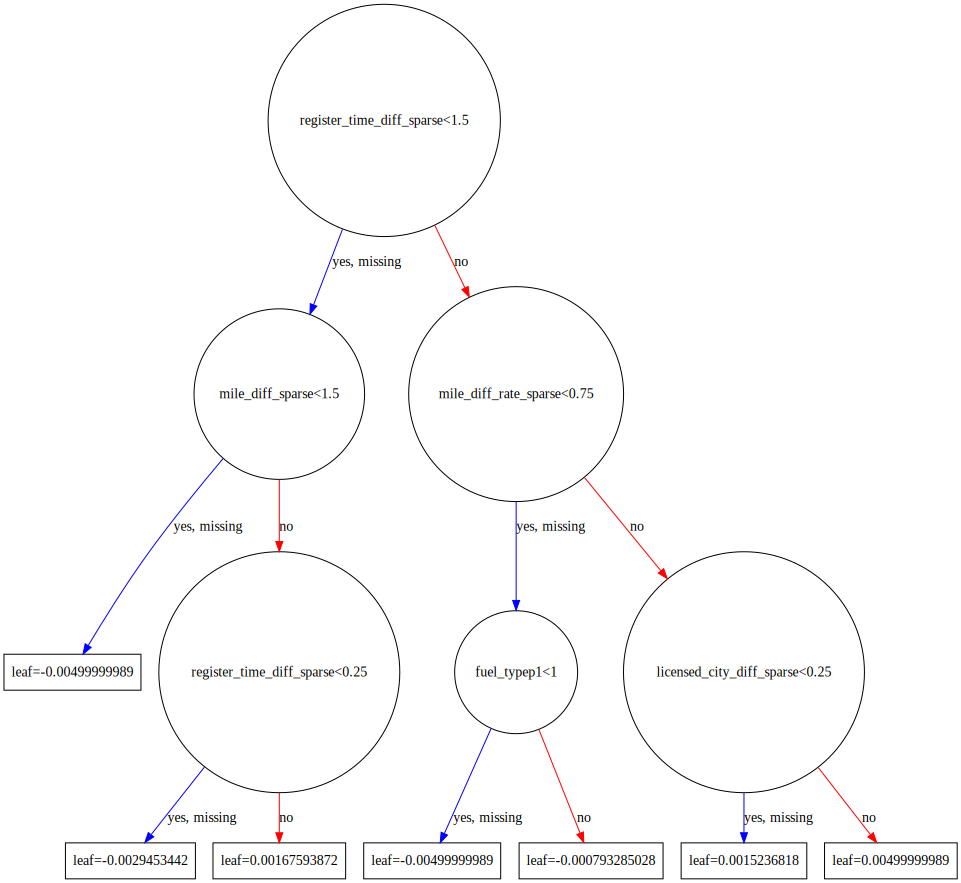

In [42]:
xgb.to_graphviz(bst)

In [15]:
### sklearn 写法
from xgboost import XGBClassifier

In [60]:
clf = XGBClassifier(n_estimators=200, max_depth=7)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classifier_evaluate(y_test, pred))
clf

{'recall': 0.9713302752293578, 'precision': 0.9713302752293578, 'accuracy': 0.9813432835820896, 'f1': 0.9763111068257322, 'tp': 847, 'fp': 25, 'tn': 1783, 'fn': 25}


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [61]:
# 绘制roc, 计算auc
probas_ = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print(f'auc{roc_auc}')
draw_lines(fpr, [tpr, fpr], ['tp', 'fp'])

auc0.9935810262239182


In [49]:
probas_[:10], pred[:10]

(array([[2.5653243e-02, 9.7434676e-01],
        [9.9447787e-01, 5.5221529e-03],
        [9.9751514e-01, 2.4848543e-03],
        [9.9931437e-01, 6.8561221e-04],
        [9.3678010e-01, 6.3219920e-02],
        [9.9264151e-01, 7.3584761e-03],
        [9.9874264e-01, 1.2573897e-03],
        [9.9809873e-01, 1.9012649e-03],
        [9.7722828e-01, 2.2771727e-02],
        [1.8727183e-02, 9.8127282e-01]], dtype=float32),
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 1])